<a href="https://colab.research.google.com/github/jtkernan7/DS-Unit-2-Classification-2/blob/master/JT_Kernan_Lending_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders shap

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 235kB 8.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/14/42/0c/c07f5fdfb68e06b525d2ba984f50c83f1e5ebd3d2680852aa5
Successfully built shap


In [0]:
# # For Google Colab, uncomment:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [0]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(current_location)

In [0]:
# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month

In [0]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

In [0]:
# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
target = 'loan_status'
X = history.drop(columns=target)
y = history[target]

In [8]:
# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 152)
y_train shape (88334,)
X_val shape (20000, 152)
y_val shape (20000,)
X_test shape (20000, 152)
y_test shape (20000,)


In [9]:
# Save the actual results, to compare later with predicted results
cols = ['id', 'issue_d', 'grade', 'percent_paid', 'term', 'int_rate']
result_train = X_train[cols].copy()
result_val = X_val[cols].copy()
result_test = X_test[cols].copy()

result_val.head()

,id,issue_d,grade,percent_paid,term,int_rate
47563,11336218.0,2014-01-01,D,1.439103,60 months,16.99%
83314,127629418.0,2018-01-01,D,1.172302,36 months,20.00%
740,555478.0,2010-08-01,D,1.217144,36 months,15.95%
60350,106493943.0,2017-04-01,C,1.158069,60 months,12.74%
121119,68368766.0,2016-01-01,A,1.048598,36 months,5.32%


In [0]:
# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [0]:
# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [13]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to integer 1-20
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (88334, 66)
X_val shape (20000, 66)
X_test shape (20000, 66)


In [14]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=100)

[0]	validation_0-auc:0.669638	validation_1-auc:0.672822
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.670802	validation_1-auc:0.674118
[2]	validation_0-auc:0.676142	validation_1-auc:0.680087
[3]	validation_0-auc:0.679771	validation_1-auc:0.683186
[4]	validation_0-auc:0.682482	validation_1-auc:0.684256
[5]	validation_0-auc:0.683905	validation_1-auc:0.685868
[6]	validation_0-auc:0.685104	validation_1-auc:0.687372
[7]	validation_0-auc:0.685857	validation_1-auc:0.687737
[8]	validation_0-auc:0.685805	validation_1-auc:0.687888
[9]	validation_0-auc:0.686504	validation_1-auc:0.689168
[10]	validation_0-auc:0.686866	validation_1-auc:0.689461
[11]	validation_0-auc:0.686938	validation_1-auc:0.689288
[12]	validation_0-auc:0.687537	validation_1-auc:0.69022
[13]	validation_0-auc:0.688371	validation_1-auc:0.690954
[14]	validation_0-auc:0.688811	validation_1-auc:0.69159

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

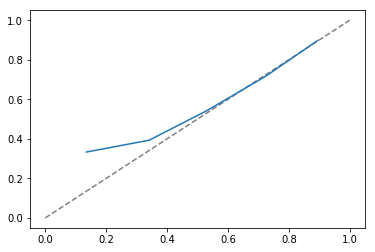

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=5)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

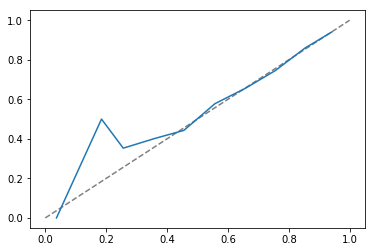

In [16]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

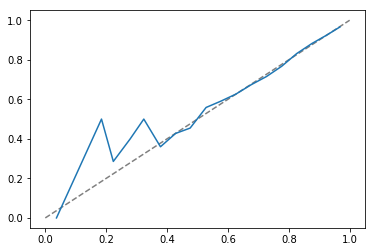

In [17]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=20)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

In [0]:
def get_results(result_df, y_true, y_pred_proba):
    result_df = result_df.copy()
    result_df['loan_status'] = y_true
    result_df['pred_proba'] = y_pred_proba
    result_df['int_rate'] = result_df['int_rate'].str.strip('%').astype(float)
    result_df['term'] = result_df['term'].str.replace(r'\D','').astype(int)
    result_df['max_interest'] = result_df['int_rate'] * result_df['term'] / 12
    result_df['best_case'] = 25 + result_df['max_interest']/100 * 25
    result_df['worst_case'] = -25
    result_df['expected_value'] = (result_df['pred_proba'] * result_df['best_case'] 
                                   + (1-result_df['pred_proba']) * result_df['worst_case'])
    return result_df

result_val = get_results(result_val, y_val, y_pred_proba)

In [22]:
result_val.head()

,id,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,max_interest,best_case,worst_case,expected_value
47563,11336218.0,2014-01-01,D,1.439103,60,16.99,Fully Paid,0.825892,84.95,46.2375,-25,33.834497
83314,127629418.0,2018-01-01,D,1.172302,36,20.00,Fully Paid,0.784076,60.00,40.0000,-25,25.964958
740,555478.0,2010-08-01,D,1.217144,36,15.95,Fully Paid,0.783144,47.85,36.9625,-25,23.525574
60350,106493943.0,2017-04-01,C,1.158069,60,12.74,Fully Paid,0.656444,63.70,40.9250,-25,18.276103
121119,68368766.0,2016-01-01,A,1.048598,36,5.32,Fully Paid,0.981405,15.96,28.9900,-25,27.986054


In [23]:
result_val.describe()

,id,percent_paid,term,int_rate,pred_proba,max_interest,best_case,worst_case,expected_value
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,5.959835e+07,1.041970,40.756800,12.189265,0.824332,42.334759,35.583690,-25.0,24.553403
std,3.961624e+07,0.267876,9.567687,3.723483,0.119848,19.270011,4.817503,0.0,5.704669
min,1.336850e+05,0.000000,36.000000,5.310000,0.036732,15.930000,28.982500,-25.0,-22.178505
25%,2.274274e+07,1.044298,36.000000,9.170000,0.760665,28.320000,32.080000,-25.0,22.151322
50%,6.136165e+07,1.113421,36.000000,12.130000,0.850720,38.220000,34.555000,-25.0,25.983663
75%,8.869767e+07,1.182077,36.000000,14.672500,0.914427,50.970000,37.742500,-25.0,28.073053
max,1.493697e+08,1.599994,60.000000,28.800000,0.995792,144.000000,61.000000,-25.0,58.244873


In [0]:
%matplotlib inline
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

def simulate(df, n_picks=40, n_sims=10000, 
             grades=['A','B','C','D'], 
             start_date='2007-07-01', 
             end_date='2019-03-01', 
             min_expected_value=-25):
    """
    What if you picked random loans for $25 investments?
    How much would you have been paid back?
    
    Repeat the simulation many times, and plot the distribution 
    of probable outcomes.
    
    This doesn't consider fees or "time value of money."
    """
    
    condition = ((df['grade'].isin(grades)) & 
                 (df['issue_d'] >= start_date) &
                 (df['issue_d'] <= end_date) & 
                 (df['expected_value'] >= min_expected_value))
    possible = df[condition]
    
    simulations = []
    for _ in tnrange(n_sims):
        picks = possible.sample(n_picks).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    print(f'#### {n_picks} loans picked from {len(possible)} possible loans')
    print(f'- Dates: {start_date}-{end_date}\n' + 
                     f'- Grades: {grades}\n' +
                     f'- Expected Value >= {min_expected_value}')
    print(f'#### Range of results from {n_sims} simulations')
    print(simulations.describe().to_string())
    plt.title(f'{percent}% of simulations did not profit.')


#### 40 loans picked from 20000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= -25
#### Range of results from 10000 simulations
count    10000.000000
mean      1042.238997
std         42.844461
min        858.318585
25%       1013.804898
50%       1044.545560
75%       1072.656103
max       1159.656155


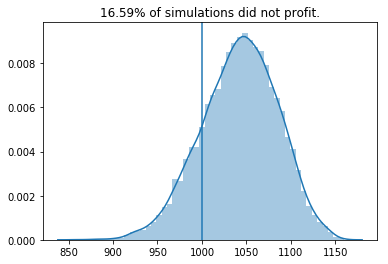

In [25]:
simulate(result_val)


#### 40 loans picked from 3986 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A']
- Expected Value >= -25
#### Range of results from 10000 simulations
count    10000.000000
mean      1051.843187
std         22.833585
min        926.708376
25%       1037.983655
50%       1054.132734
75%       1068.560267
max       1105.316116


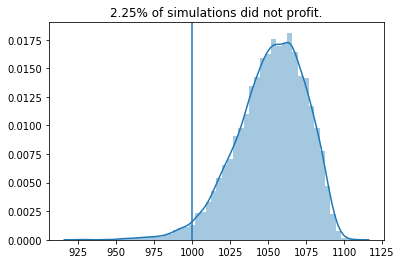

In [26]:
simulate(result_val, grades=['A'])


#### 40 loans picked from 4000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= 28.48930935239792
#### Range of results from 10000 simulations
count    10000.000000
mean      1101.815444
std         33.841194
min        948.688770
25%       1080.080267
50%       1103.421605
75%       1125.257071
max       1210.574689


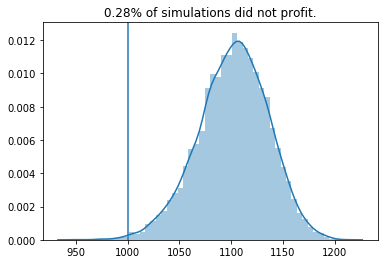

In [27]:
import numpy as np
min_expected_value = np.percentile(result_val['expected_value'], 80)
simulate(result_val, min_expected_value=min_expected_value)

In [28]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.710612839736205



#### 40 loans picked from 4000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= 28.49813384616375
#### Range of results from 10000 simulations
count    10000.000000
mean      1091.853443
std         36.511854
min        925.766255
25%       1068.773657
50%       1093.676419
75%       1117.758862
max       1213.018389


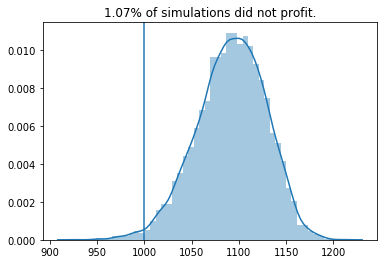

In [29]:
result_test = get_results(result_test, y_test, y_pred_proba)
min_expected_value = np.percentile(result_test['expected_value'], 80)
simulate(result_test, min_expected_value=min_expected_value)

In [30]:
df = result_test.copy()
condition = (df['expected_value'] >= min_expected_value)
possible = df[condition]
picks = possible.sample(40, random_state=42).copy()
picks

,id,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,max_interest,best_case,worst_case,expected_value
23419,97202338.0,2017-01-01,B,1.000411,36,11.39,Fully Paid,0.956969,34.17,33.5425,-25,31.023348
124412,39760290.0,2015-01-01,B,1.168460,36,10.49,Fully Paid,0.938054,31.47,32.8675,-25,29.282852
64773,3731877.0,2013-03-01,C,1.014397,36,17.27,Fully Paid,0.873706,51.81,37.9525,-25,30.001957
62529,129919441.0,2018-03-01,B,1.035910,36,9.43,Fully Paid,0.954238,28.29,32.0725,-25,29.460769
72870,75728457.0,2016-03-01,C,1.042677,60,11.99,Fully Paid,0.904825,59.95,39.9875,-25,33.802344
101219,129464797.0,2018-03-01,B,1.019515,36,9.43,Fully Paid,0.939524,28.29,32.0725,-25,28.620956
85131,37821587.0,2015-01-01,C,0.640316,60,13.66,Charged Off,0.845039,68.30,42.0750,-25,31.681008
25346,142082372.0,2018-10-01,A,1.024170,36,7.21,Fully Paid,0.974873,21.63,30.4075,-25,29.015283
71871,12916566.0,2014-03-01,C,1.324259,60,14.64,Fully Paid,0.796981,73.20,43.3000,-25,29.433772
127692,2309337.0,2012-12-01,A,1.111432,36,7.62,Fully Paid,0.968341,22.86,30.7150,-25,28.951142


In [31]:
data_for_prediction = X_test[X_test.index==106384]
data_for_prediction

,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,collections_12_mths_ex_med,delinq_amnt,desc_NULL,dti,dti_joint,earliest_cr_line,emp_length,emp_length_NULL,emp_title,emp_title_NULL,emp_title_owner,fico_range_high,funded_amnt,home_ownership,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d_month,issue_d_year,loan_amnt,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_last_major_derog_NULL,mths_since_last_record,mths_since_recent_bc,mths_since_recent_inq,num_actv_bc_tl,num_actv_rev_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m_NULL,open_rv_12m_NULL,open_rv_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,purpose,revol_bal,revol_bal_joint,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_open_acc,sec_app_open_act_il,sub_grade,term,title,title_NULL,tot_coll_amt,tot_hi_cred_lim,total_acc,total_bal_il,total_bc_limit,total_cu_tl,total_rev_hi_lim
106384,0.0,FL,NaN,140000.0,NaN,30333.0,26371.0,43.9,0.0,0.0,True,15.22,NaN,7548,10.0,False,16.0,False,False,724.0,33000.0,MORTGAGE,NaN,1.0,1090.88,11.67,6,2014,33000.0,NaN,205.0,247.0,28.0,3.0,True,NaN,30.0,1.0,5.0,9.0,11.0,9.0,False,True,NaN,100.0,33.3,0.0,credit_card,31786.0,NaN,NaN,NaN,NaN,NaN,9,36 months,23.0,False,0.0,615094.0,34.0,NaN,47000.0,NaN,60600.0


In [0]:
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns

In [33]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


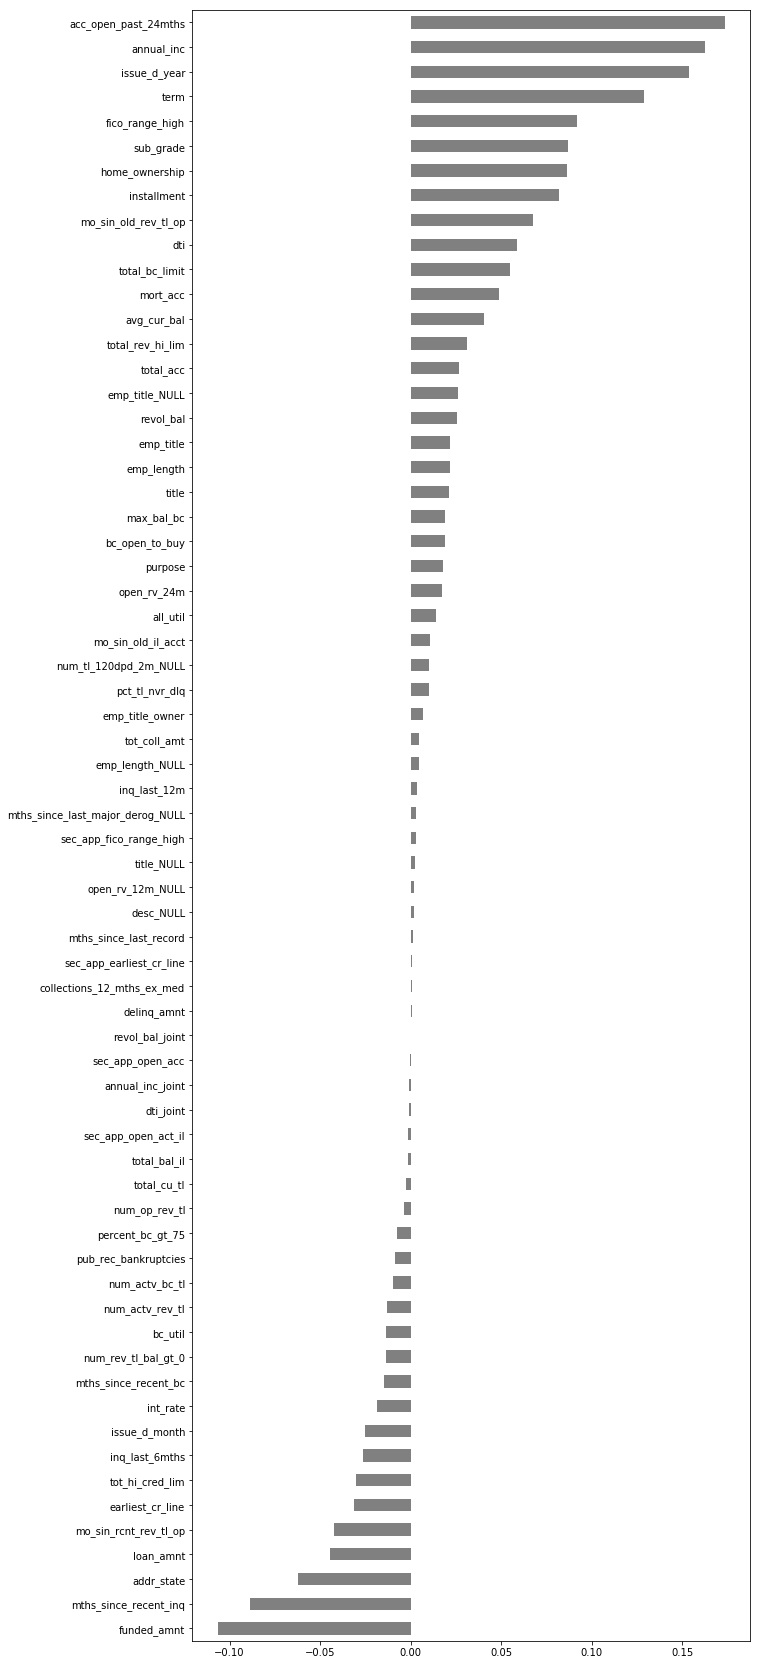

In [34]:
plt.figure(figsize=(10,30))
pd.Series(shap_values[0], X_test.columns).sort_values().plot.barh(color='grey');